In [1]:
from astropy.time import Time, TimeDelta
from poliastro.twobody import Orbit
from poliastro.bodies import Earth
from astropy import units as u
import numpy as np
import matplotlib.pyplot  as plt
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True, precision=6)

# Step 1. Defining state transition 

In [2]:
# Define the state transition function
def fx(x, dt):
    # print(f"x: {x}")
    orbit = Orbit.from_vectors(Earth, x[:3] * u.km, x[3:] * u.km / u.s)
    # print(orbit.r.to(u.km).value, orbit.v.to(u.km / u.s).value)
    # print(TimeDelta(dt * u.s))
    orbit = orbit.propagate(TimeDelta(dt * u.s)) # seconds!
    new_pos, new_vel = orbit.r.to(u.km).value, orbit.v.to(u.km / u.s).value
    return np.hstack((new_pos, new_vel))

# Define the measurement function
def hx(x):
    return x

# Step 2. SR-UKF Definition

In [3]:
# reference: https://github.com/Al-khwarizmi-780/OpenKF/blob/main/python/examples/Square_Root_Unscented_Kalman_Filter.ipynb

def cholupdate(L, W, beta):
    """ updating sqrt_cov directly """
    r = np.shape(W)[1]
    m = np.shape(L)[0]
    for i in range(r):
        L_out = np.copy(L)
        b = 1.0
        for j in range(m):
            Ljj_pow2 = L[j, j]**2
            wji_pow2 = W[j, i]**2
            #=============================================
            xxx = Ljj_pow2 + (beta / b) * wji_pow2
            # if (xxx < 0):
            #     continue
            #     print(xxx)
            #     asdf
            #     xxx = 1e-6
            #=============================================
            L_out[j, j] = np.sqrt(xxx)
            upsilon = (Ljj_pow2 * b) + (beta * wji_pow2)
            for k in range(j+1, m):
                W[k, i] -= (W[j, i] / L[j,j]) * L[k,j]
                L_out[k, j] = ((L_out[j, j] / L[j, j]) * L[k,j]) + (L_out[j, j] * beta * W[j, i] * W[k, i] / upsilon)
            b += beta * (wji_pow2 / Ljj_pow2)
        L = np.copy(L_out)
    return L_out

def forwardsubs(A, B):
    """"""
    N = np.shape(A)[0]
    X = np.zeros((B.shape[0], B.shape[1]))
    for k in range(B.shape[1]):
        for i in range(N):
            sum_aij_xj = B[i, k]
            for j in range(i):
                sum_aij_xj -= A[i, j] * X[j, k]                
            X[i, k] = sum_aij_xj / A[i, i]
    return X

def backsubs(A, B):
    N = np.shape(A)[0]
    X = np.zeros((B.shape[0], B.shape[1]))    
    for k in range(B.shape[1]):
        for i in range(N-1, -1, -1):
            sum_aij_xj = B[i, k]
            for j in range(N-1, i, -1):
                sum_aij_xj -= A[i, j] * X[j, k]
            X[i, k] = sum_aij_xj / A[i, i]
    return X

class SquareRootUKF(object):
    def __init__(self, x, P, Q, R, alpha=1, beta=2, kappa=3):
        self.dim_x = np.shape(x)[0]
        print(f"dim_x = {self.dim_x}")
        self.n_sigmas = (2 * self.dim_x) + 1
        

        # UKF parameters
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.lamb = self.alpha**2 * (self.dim_x + self.kappa) - self.dim_x
        print(f"lambda = {self.lamb}")

        # self.kappa = 6 - self.dim_x
        
        self.gamma = np.sqrt(self.dim_x + self.kappa) # scale factor to control the spread of the sigma point
        print(f"gamma = {self.gamma}")
        
        self.Wm0 = self.kappa / (self.dim_x + self.lamb)
        self.Wm = 0.5 / (self.dim_x + self.lamb)
        self.Wc0 = self.Wm0 + (1 - self.alpha**2 + self.beta)
        self.Wc = self.Wm
        
        self.x = x

        self.meas_diff = np.zeros((self.dim_x))
        
        # lower triangular matrices
        # print(f"init: p shape:{P.shape}")
        self.sqrt_P = np.linalg.cholesky(P) # sqrt of state cov mat
        # print(f"sqrt_P shape {self.sqrt_P.shape}")
        self.sqrt_Q = np.linalg.cholesky(Q) # sqrt of process noise
        self.sqrt_R = np.linalg.cholesky(R) # sqrt of meas noise
        # print(f'R = \n{R}\n')

    def sigma_points(self, x, sqrt_P):        
        '''
        generating sigma points matrix x_sigma given mean 'x' and square-root covariance 'S'
        '''
        # print(self.dim_x)
        sigmas_X = np.zeros((self.dim_x, self.n_sigmas))       
        # print(sigmas_X.shape)
        sigmas_X[:, 0] = x

        # print(sqrt_P.shape)
        # print(x.shape)

        for i in range(self.dim_x):
            idx_1 = i + 1
            idx_2 = i + self.dim_x + 1            
            sigmas_X[:, idx_1] = x + (self.gamma * sqrt_P[:, i])
            sigmas_X[:, idx_2] = x - (self.gamma * sqrt_P[:, i])
            
        return sigmas_X
    
    def predict(self, fx_prop, dt):
        # generate sigma points
        sigmas_X = self.sigma_points(self.x, self.sqrt_P)
        # print("first sigma points")
        # print(sigmas_X)
        
        # propagate sigma points through the nonlinear function
        for i in range(self.n_sigmas):
            sigmas_X[:, i] = fx_prop(sigmas_X[:, i], dt)
        
        # calculate weighted mean
        x_pred = self.Wm0 * sigmas_X[:, 0]
        for i in range(1, self.n_sigmas):
            x_pred += self.Wm * sigmas_X[:, i]
        
        # build compound matrix for square-root covariance update
        # sigmas_X[:, 0] is not added because W0 could be zero which will lead to undefined outcome from sqrt(W0).
        C = (sigmas_X[:, 1:].T - x_pred) * np.sqrt(self.Wm)
        C = np.concatenate((C, self.sqrt_Q.T), axis=0)
        
        # calculate square-root covariance S using QR decomposition of compound matrix C
        # including the process noise covariance
        Q , S_minus = np.linalg.qr(C)
        # print(f'Q = \n{Q}\n')
        # print(f'R = \n{S_minus}\n')
        
        # Rank-1 cholesky update
        x_dev = sigmas_X[:, 0] - x_pred  # get the deviation only from the sigma point
        x_dev = np.reshape(x_dev, [-1, 1])
        # print(f'x_dev = \n{x_dev}\n')
        S_minus = cholupdate(S_minus.T, x_dev, self.Wm0)
        
        # overwrite member x and S
        self.x = x_pred
        self.sqrt_P = S_minus
        
        # print(f'S^- = \n{S_minus}\n')
    
    
    def correct(self, hx, z):
        # generate sigma points X
        sigmas_X = self.sigma_points(self.x, self.sqrt_P)
        
        # propagate sigma points X through the nonlinear function
        # to get output sigma points Y
        dim_z = np.shape(z)[0]
        sigmas_Y = np.zeros((dim_z, self.n_sigmas))
        for i in range(self.n_sigmas):
            sigmas_Y[:, i] = hx(sigmas_X[:, i])
        
        # print(f'Ys = \n{sigmas_Y}\n')
        
        # calculate weighted mean y
        y_bar = self.Wm0 * sigmas_Y[:, 0]
        for i in range(1, self.n_sigmas):
            y_bar += self.Wm * sigmas_Y[:, i]
    
        # print(f'y = \n{y_bar}\n')
        
        # build compound matrix for square-root covariance update      
        C = (sigmas_Y[:, 1:].T - y_bar) * np.sqrt(self.Wm)       
        C = np.concatenate((C, self.sqrt_R.T), axis=0)
        
        # print(f'sqrt_R.T = \n{self.sqrt_R.T}\n')
        
        # calculate square-root covariance S using QR decomposition of compound matrix C
        # including the process noise covariance
        _ , S_y = np.linalg.qr(C)
        
        # Rank-1 cholesky update
        y_dev = sigmas_Y[:, 0] - y_bar
        y_dev = np.reshape(y_dev, [-1, 1])
        S_y = cholupdate(S_y.T, y_dev, self.Wm0)
        # print(f'Sy = \n{S_y}\n')
           
        # calculate cross-correlation
        Pxy = self.calculate_cross_correlation(self.x, sigmas_X, y_bar, sigmas_Y)
        # print(f'Pxy = \n{Pxy}\n')
        
        # Kalman gain calculation with two nested least-squares
        # Step1: Forward-substitution -> K = Sy \ Pxy  (since S_y is lower-triangular)
        # Step2: Backward-substitution -> K = Sy.T \ K (since S_y.T is upper-triangular)
        K = forwardsubs(S_y, Pxy)
        K = backsubs(S_y.T, K)
        # print(f'K = \n{K}\n')
        
        # update state vector x
        self.meas_diff = z - y_bar
        self.x += K @ (self.meas_diff)

        
        
        # update state square-root covariance Sk
        # S_y must be upper triangular matrix at this place
        U = K @ S_y
        
        #self.sqrt_P = r_rank_cholupdate_v2(self.sqrt_P, U, -1.0)
        self.sqrt_P = cholupdate(self.sqrt_P, U, -1.0)
    
    def calculate_cross_correlation(self, x, x_sigmas, y, y_sigmas):
        xdim = np.shape(x)[0]
        ydim = np.shape(y)[0]
        
        n_sigmas = np.shape(x_sigmas)[1]
    
        dx = (x_sigmas[:, 0] - x).reshape([-1, 1])
        dy = (y_sigmas[:, 0] - y).reshape([-1, 1])
        Pxy = self.Wc * (dx @ dy.T)
        for i in range(1, n_sigmas):
            dx = (x_sigmas[:, i] - x).reshape([-1, 1])
            dy = (y_sigmas[:, i] - y).reshape([-1, 1])
            Pxy += self.Wc * (dx @ dy.T)
    
        return Pxy

# Step 3. Loading Data

In [4]:
npzfile = np.load('GPS_meas.npz', allow_pickle=True)

noisy_measurement = npzfile['measurements']
t_measurement = npzfile['t_measurements']
# Convert measurement times to Time objects
t_measurement_time = Time(t_measurement)

N = len(t_measurement) # Number of measurements.

# Calculate time intervals (dt) between consecutive measurements
dt_list = (t_measurement_time[1:] - t_measurement_time[:-1]) # TimeDelta object. Shape: (720,)
print(dt_list[100].sec)


604.0000230073929


# Step 4. Inital States, Covariance, process and measurement noise

Folling popular strateg:


$$\kappa >= 0$$

$$ 0< \alpha <=1 $$

$$ \beta = 2 $$

$$ \lambda = \alpha^2(n+k) - n $$

$$ \gamma = \sqrt(n+\lambda)  = \sqrt(\alpha^2(n+k)) $$

$$ X_i = \mu \pm \gamma\sqrt(P) $$

- For $\gamma$ Minimum k is -6 for dim is 6 and sqrt>=0
- the distribution is sigma points depends on weights, which again depends on lambda, we want "well" distributed sigma points to capture the nonlinearity.


## Discussion

### 1. Setting kappa = 0. 

As gamma is just a constant, simply adjusting alpha = controlling gamma.
  
Given above, gamma needs to be chosen so that the sigma points are spread out well to capture the nonlinearity of the motion. But not too much. So reducing alpha from 1 to 0.9965 was achived.

### 2. What happens if alpha (gamma) is too small? 
It seems the fx() and the covariance estiamtion does not go well. During the downdate process of the sqrt_P, there seems to be error as a factor in sqrt() becomes negative. The best explanation so far is the the covariance estimation is too small while the actual motion deviates alot due to the nonliearity.

### 3. Initial State Covaraince Matrix
Using convention, set to eye(6)

### 4. Inital process and measurement noise matrices
Started from both eye(6)*0.1. 

Next, it is noticed that the the orbit propagation model only shows constant oscialltion. Based on the email discussion, the default motion does not seem to capture any external forces such as drag. It is also obvious that the orbit function model does not seem to accept other arugments to capture the drag or so (as far as the given script by helper_functions.ipynb). Therefore, it is reasonable to assume this "uncaptured" external force may be regarded as process noise.

On the other hand, the decaying motion is captured by the measurment but with some noise. Also, based on the email discussion, the noise does not have bias or decaying bias. Intead it only has gaussian noise and by its value, the level of the noise is relatively small for position estimation. Therfore, it is reasonable to conclude that the captured decay from the measurement is quite closer to the true dyanmics + noise.


### 5. Challenges
The cholupdate function is based on the scale factor beta, which is determined by the paramters above. Indeed, the estimation of the covariance evolution along with the state transition remains murkey. As the true convariance evolution is only plausible using the linear system i.e $ P = A\Sigma A^T + Q $ Thus, the covariance evolution depends on the scale factor beta. 

In practice, the beta can end upwith negative values in the square root calculation. The ad-hoc staterategies tested here are 1. ignore the update, 2. threshold it to small value, or 3. tune the inital parameters from the beginning so that this does not happen. However, based on the noise, dyamics, the strategy needs to be selected accordingly.


### 6. Additional Thoughts
The sampling rate seems to be quite low. The higher sampling rate would have helped the estimation better. By the last plot, estimated state - measruement, the error is somehow too good to be true. This may mean the estimation has given too much weights to the measuremenht signal. However, by reducing R, the measurement noise, may not capture the decaying motion well. 

dim_x = 6
lambda = -1.1999994000255754e-05
gamma = 2.449489742783178
wm0: 0.0, wm: 0.08333350000025, wc0: 2.000001999999, wc: 0.08333350000025
sigmas_X = 
[[ 3235.641715  3238.091205  3235.641715  3235.641715  3235.641715  3235.641715  3235.641715  3233.192225  3235.641715  3235.641715  3235.641715  3235.641715  3235.641715]
 [ 2693.72566   2693.72566   2696.17515   2693.72566   2693.72566   2693.72566   2693.72566   2693.72566   2691.27617   2693.72566   2693.72566   2693.72566   2693.72566 ]
 [-5335.427936 -5335.427936 -5335.427936 -5332.978446 -5335.427936 -5335.427936 -5335.427936 -5335.427936 -5335.427936 -5337.877425 -5335.427936 -5335.427936 -5335.427936]
 [   -4.8743      -4.8743      -4.8743      -4.8743      -2.42481     -4.8743      -4.8743      -4.8743      -4.8743      -4.8743      -7.32379     -4.8743      -4.8743  ]
 [    5.898793     5.898793     5.898793     5.898793     5.898793     8.348283     5.898793     5.898793     5.898793     5.898793     5.898793     3.449304

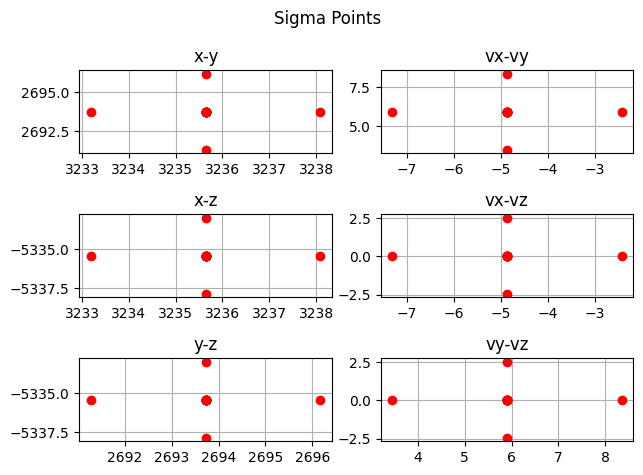

In [5]:
# Initial state vector
position = [3235.64171524, 2693.72565982, -5335.42793567] 
velocity = [-4.87430005, 5.89879341, 0.01977648] 
x = np.hstack((position, velocity)) # initial state vector. Shape: (6,)


# Process & measurement noise
#=======================================================================================================
P = np.eye(6)
Q = np.eye(6)*10**-4 # Process noise covariance. Shape: (6, 6)
#Q[:3, :3] = np.eye(3)*10**3
R = np.eye(6)*10**3 # Measurement noise covariance. Shape: (6, 6) 
#=======================================================================================================
sr_ukf = SquareRootUKF(x, P, Q, R, alpha=1-1e-6, beta=2, kappa=0)

# sample sigma points
sigmas_X = sr_ukf.sigma_points(sr_ukf.x, sr_ukf.sqrt_P)
print(f"wm0: {sr_ukf.Wm0}, wm: {sr_ukf.Wm}, wc0: {sr_ukf.Wc0}, wc: {sr_ukf.Wc}")
print(f"sigmas_X = \n{sigmas_X}\n")

for i in range(sigmas_X.shape[0]):
    ppss = fx(sigmas_X[:, 0], 1)
    print(f"ppss = {ppss}")


sp = sigmas_X.T #(N, 6)

plt.figure()
plt.suptitle('Sigma Points')
plt.subplot(3,2,1)
plt.plot(sp[:,0], sp[:,1], 'ro')
plt.title('x-y')
plt.grid()
plt.subplot(3,2,3)
plt.plot(sp[:,0], sp[:,2], 'ro')
plt.title('x-z')
plt.grid()
plt.subplot(3,2,5)
plt.plot(sp[:,1], sp[:,2], 'ro')
plt.title('y-z')
plt.grid()
plt.subplot(3,2,2)
plt.plot(sp[:,3], sp[:,4], 'ro')
plt.title('vx-vy')
plt.grid()
plt.subplot(3,2,4)
plt.plot(sp[:,3], sp[:,5], 'ro')
plt.title('vx-vz')
plt.grid()
plt.subplot(3,2,6)
plt.plot(sp[:,4], sp[:,5], 'ro')
plt.title('vy-vz')
plt.tight_layout()
plt.grid()



In [6]:
states = [x]
states_cov = [P]
meas_diff = [[0,0,0,0,0,0]]

for i in range (1, N):
    if (i % 100 == 0):
        print(f"Iteration {i}")
    
    sr_ukf.predict(fx, dt_list[i-1].sec)
    # print("state after pred")
    # print(sr_ukf.x)
    # print(sr_ukf.x.shape)
    # print("sqrt_P")
    # print(sr_ukf.sqrt_P)
    sr_ukf.correct(hx, noisy_measurement[i])
    # print("state after corr")
    # print(sr_ukf.x)
    # print("sqrt_P")
    # print(sr_ukf.sqrt_P)
    meas_diff.append(sr_ukf.meas_diff)
    states_cov.append(sr_ukf.sqrt_P@sr_ukf.sqrt_P.T)
    states.append(sr_ukf.x)

states = np.array(states)
states_cov = np.array(states_cov)
meas_diff = np.array(meas_diff)
print(meas_diff.shape)

np.save("srukf.npy" , states)
np.save("srukf_cov.npy" , states_cov)


Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
(721, 6)


# States Plot Position and Velocity

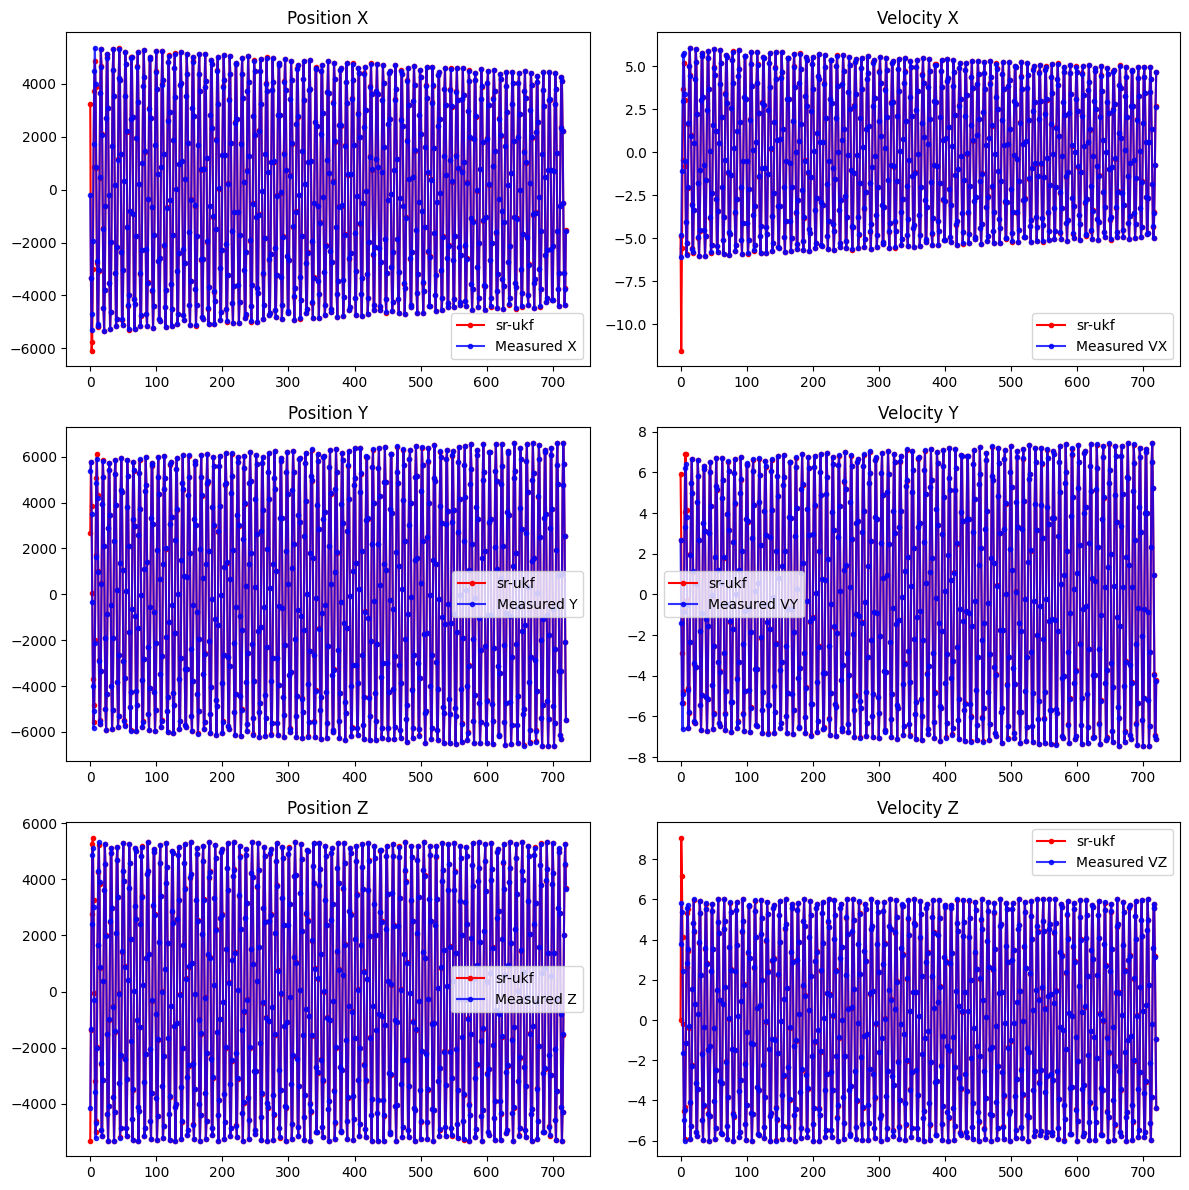

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].plot(states[:, 0], '.-', label='sr-ukf', color='red')
axs[0, 0].plot(noisy_measurement[:, 0], '.-', label='Measured X', color='blue', alpha=0.8)
axs[0, 0].set_title('Position X')
axs[0, 0].legend(loc='best')

axs[1, 0].plot(states[:, 1], '.-', label='sr-ukf', color='red')
axs[1, 0].plot(noisy_measurement[:, 1], '.-', label='Measured Y', color='blue', alpha=0.8)
axs[1, 0].set_title('Position Y')
axs[1, 0].legend(loc='best')

axs[2, 0].plot(states[:, 2], '.-', label='sr-ukf', color='red')
axs[2, 0].plot(noisy_measurement[:, 2], '.-', label='Measured Z', color='blue', alpha=0.8)
axs[2, 0].set_title('Position Z')
axs[2, 0].legend(loc='best')

axs[0, 1].plot(states[:, 3], '.-', label='sr-ukf', color='red')
axs[0, 1].plot(noisy_measurement[:, 3], '.-', label='Measured VX', color='blue', alpha=0.8)
axs[0, 1].set_title('Velocity X')
axs[0, 1].legend(loc='best')

axs[1, 1].plot(states[:, 4], '.-', label='sr-ukf', color='red')
axs[1, 1].plot(noisy_measurement[:, 4], '.-', label='Measured VY', color='blue', alpha=0.8)
axs[1, 1].set_title('Velocity Y')
axs[1, 1].legend(loc='best')

axs[2, 1].plot(states[:, 5], '.-', label='sr-ukf', color='red')
axs[2, 1].plot(noisy_measurement[:, 5], '.-', label='Measured VZ', color='blue', alpha=0.8)
axs[2, 1].set_title('Velocity Z')
axs[2, 1].legend(loc='best')

plt.tight_layout()
plt.show()

# Uncertainty of the estimated states by SR-UKF

(721, 6, 6)


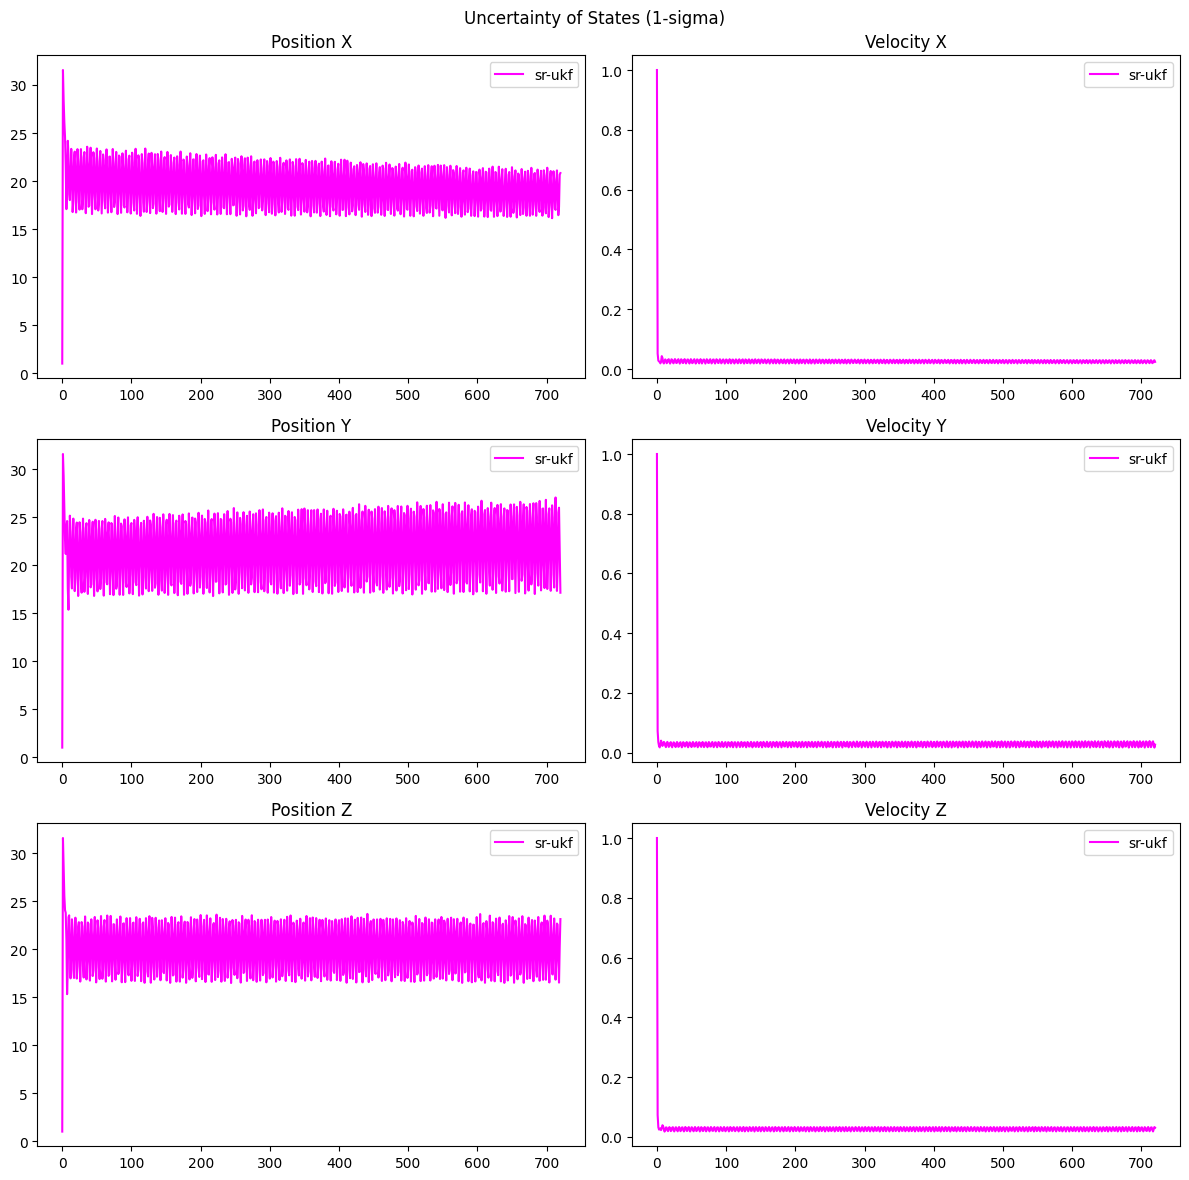

In [8]:
print(states_cov.shape) # Nx6x6
N = states_cov.shape[0]
# get standard diviation for pos vel xyz
states_std = np.zeros((N, 6))
for i in range(N):
    states_std[i] = np.sqrt(np.diag(states_cov[i]))

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.suptitle('Uncertainty of States (1-sigma)')

axs[0, 0].plot(states_std[:, 0], '-', label='sr-ukf', color='magenta')
axs[0, 0].set_title('Position X')
axs[0, 0].legend()

axs[1, 0].plot(states_std[:, 1], '-', label='sr-ukf', color='magenta')
axs[1, 0].set_title('Position Y')
axs[1, 0].legend()

axs[2, 0].plot(states_std[:, 2], '-', label='sr-ukf', color='magenta')
axs[2, 0].set_title('Position Z')
axs[2, 0].legend()

axs[0, 1].plot(states_std[:, 3], '-', label='sr-ukf', color='magenta')
axs[0, 1].set_title('Velocity X')
axs[0, 1].legend()

axs[1, 1].plot(states_std[:, 4], '-', label='sr-ukf', color='magenta')
axs[1, 1].set_title('Velocity Y')
axs[1, 1].legend()

axs[2, 1].plot(states_std[:, 5], '-', label='sr-ukf', color='magenta')
axs[2, 1].set_title('Velocity Z')
axs[2, 1].legend()

plt.tight_layout()
plt.show()



# Example of States and Uncertain Together

For the visual purpose, a subset of the data is used.

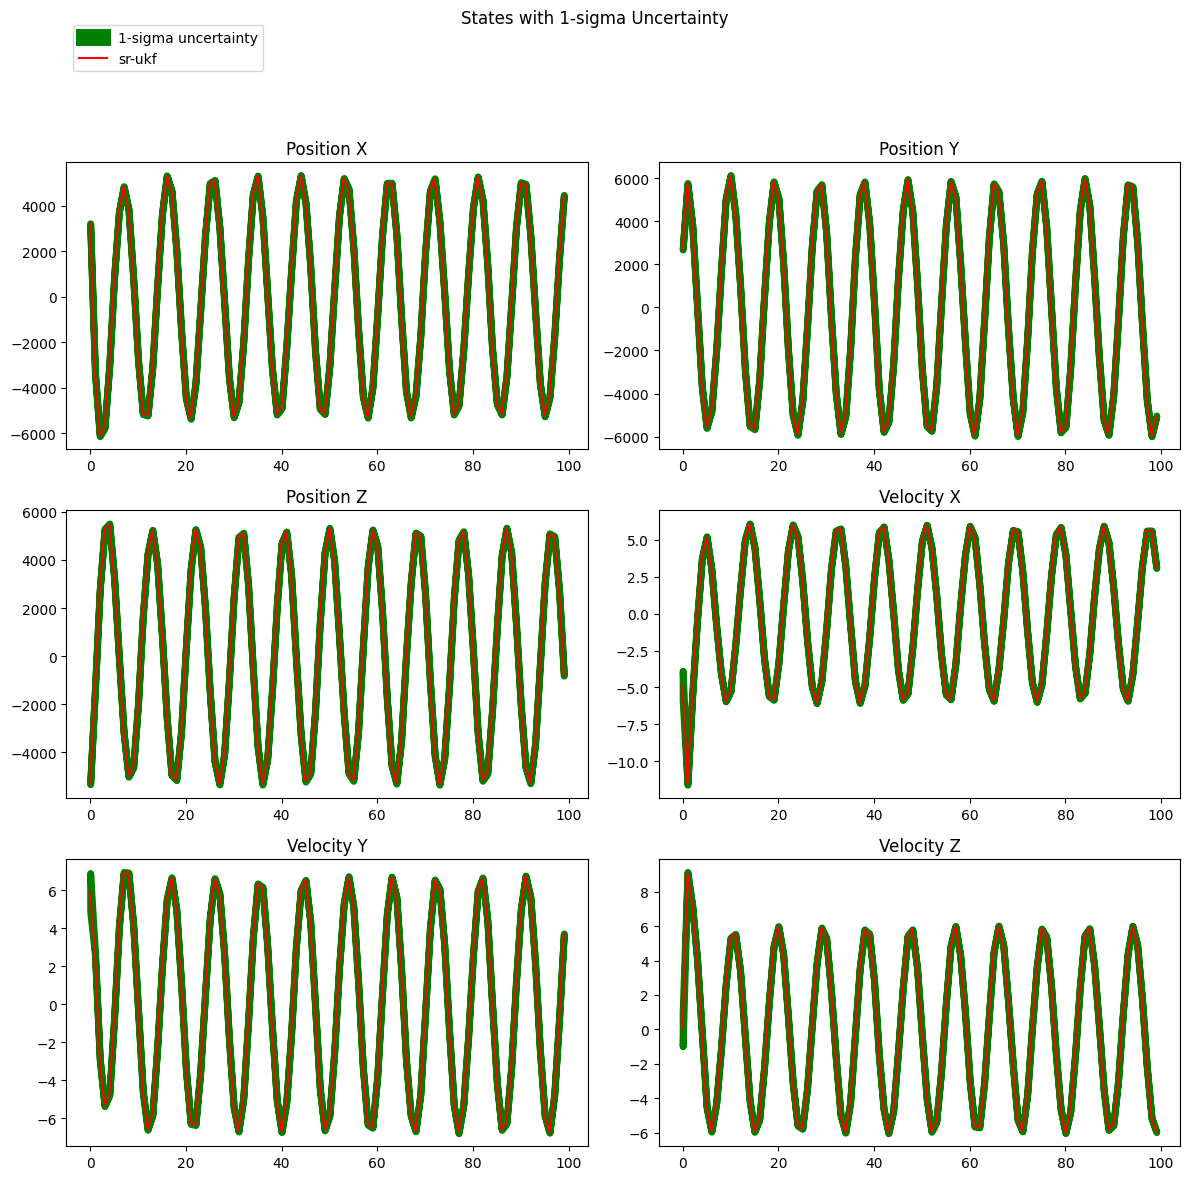

In [9]:
Nlim = 100
# get standard diviation for pos vel xyz
states_std = np.zeros((N, 6))
for i in range(N):
    states_std[i] = np.sqrt(np.diag(states_cov[i]))

# plot states with 1-sigma uncertainty bars for each state
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.suptitle('States with 1-sigma Uncertainty')

titles = ['Position X', 'Position Y', 'Position Z', 'Velocity X', 'Velocity Y', 'Velocity Z']

for i in range(6):
    row, col = divmod(i, 2)
    axs[row, col].fill_between(np.arange(Nlim), states[:Nlim, i] - states_std[:Nlim, i], states[:Nlim, i] + states_std[:Nlim, i], color='green', alpha=1, label='1-sigma uncertainty', linewidth=5)
    axs[row, col].plot(states[:Nlim, i], '-', label='sr-ukf', color='red')
    axs[row, col].set_title(titles[i])
    if (i == 0):
        legend = axs[row, col].legend(loc='upper left', bbox_to_anchor=(0, 1.5))
    
    
# Adjust layout to make room for the legends
plt.tight_layout()

# Display the plot
plt.show()


# Measurement Difference

$E = h(x) - z$

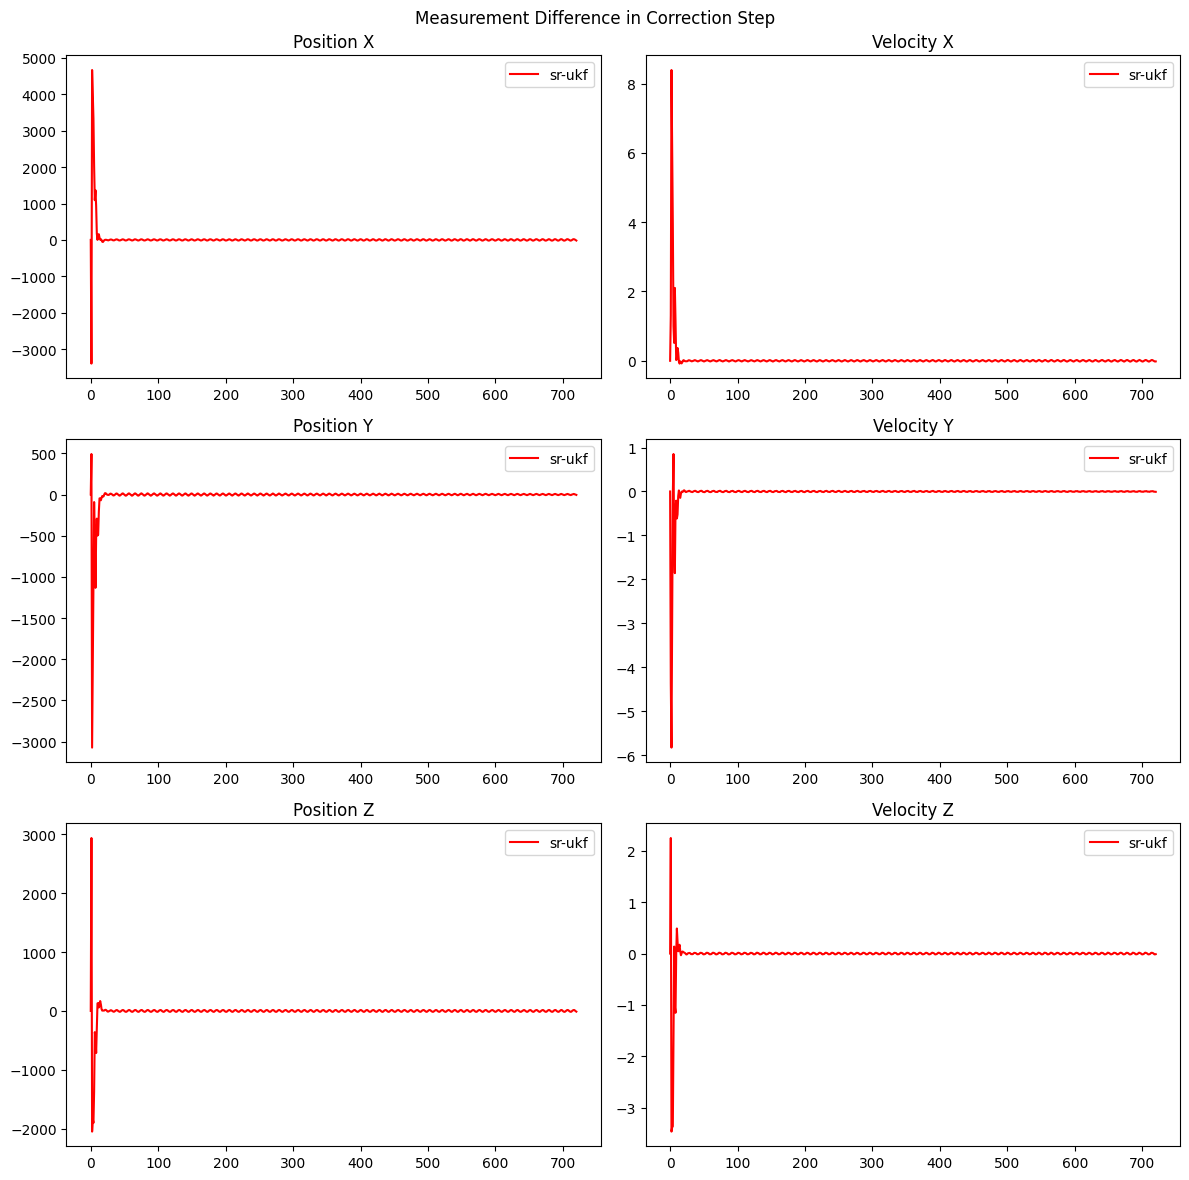

In [10]:

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.suptitle('Measurement Difference in Correction Step')

axs[0, 0].plot(meas_diff[:, 0], '-', label='sr-ukf', color='red')
axs[0, 0].set_title('Position X')
axs[0, 0].legend()

axs[1, 0].plot(meas_diff[:, 1], '-', label='sr-ukf', color='red')
axs[1, 0].set_title('Position Y')
axs[1, 0].legend()

axs[2, 0].plot(meas_diff[:, 2], '-', label='sr-ukf', color='red')
axs[2, 0].set_title('Position Z')
axs[2, 0].legend()

axs[0, 1].plot(meas_diff[:, 3], '-', label='sr-ukf', color='red')
axs[0, 1].set_title('Velocity X')
axs[0, 1].legend()

axs[1, 1].plot(meas_diff[:, 4], '-', label='sr-ukf', color='red')
axs[1, 1].set_title('Velocity Y')
axs[1, 1].legend()

axs[2, 1].plot(meas_diff[:, 5], '-', label='sr-ukf', color='red')
axs[2, 1].set_title('Velocity Z')
axs[2, 1].legend()

plt.tight_layout()

plt.show()


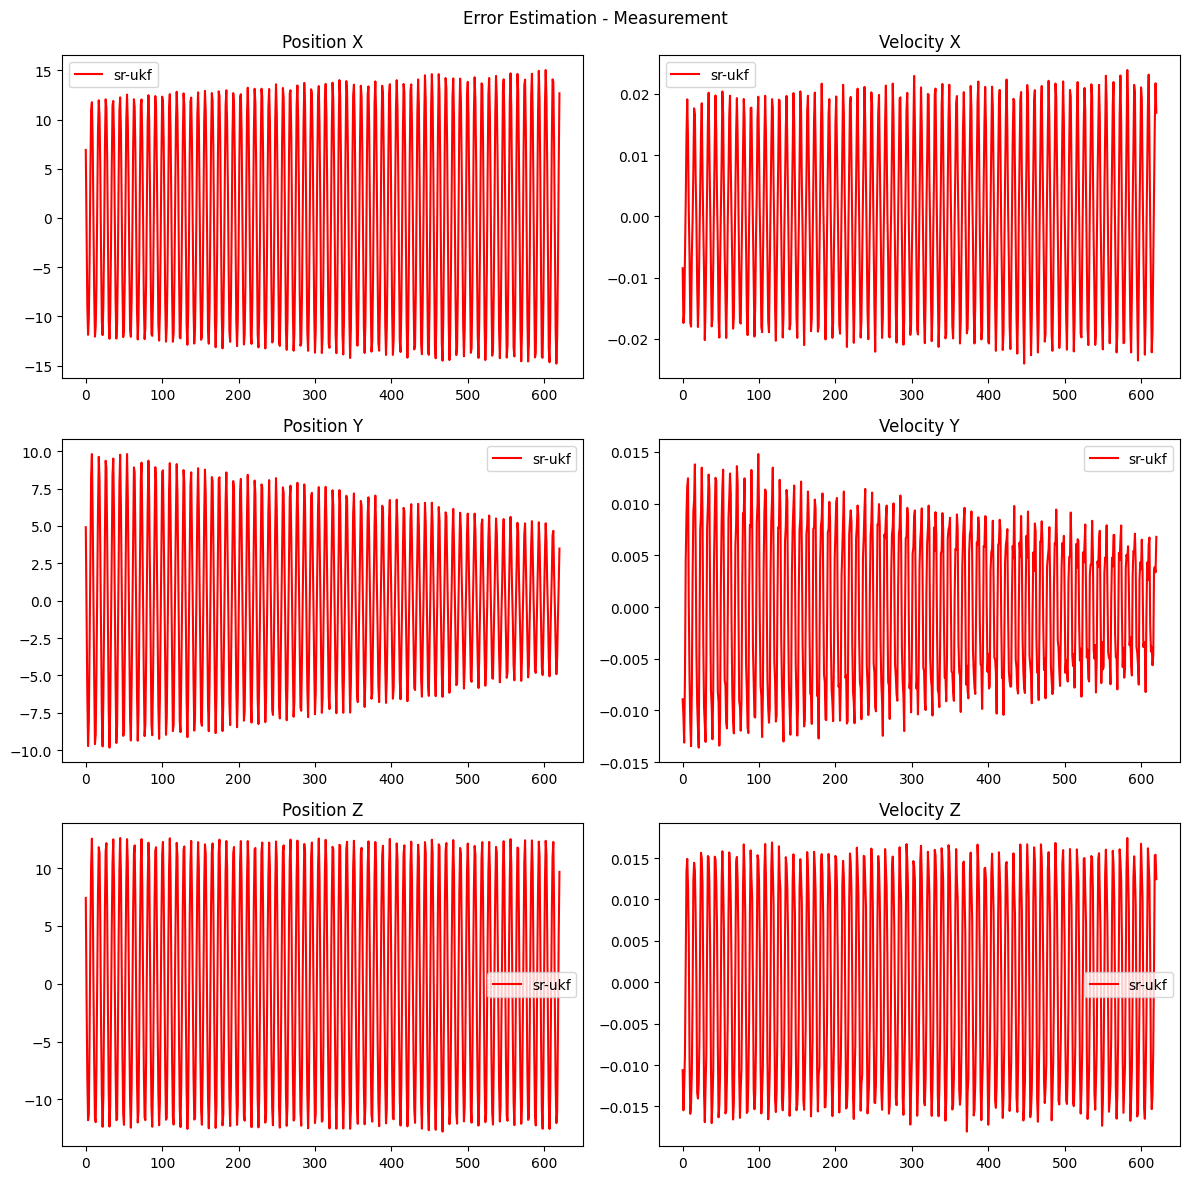

In [12]:
# Estimation  - Measurement

sdiff = states - noisy_measurement
sdiff = sdiff[100:]
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.suptitle('Error Estimation - Measurement')

axs[0, 0].plot(sdiff[:, 0], '-', label='sr-ukf', color='red')
axs[0, 0].set_title('Position X')
axs[0, 0].legend()

axs[1, 0].plot(sdiff[:, 1], '-', label='sr-ukf', color='red')
axs[1, 0].set_title('Position Y')
axs[1, 0].legend()

axs[2, 0].plot(sdiff[:, 2], '-', label='sr-ukf', color='red')
axs[2, 0].set_title('Position Z')
axs[2, 0].legend()

axs[0, 1].plot(sdiff[:, 3], '-', label='sr-ukf', color='red')
axs[0, 1].set_title('Velocity X')
axs[0, 1].legend()

axs[1, 1].plot(sdiff[:, 4], '-', label='sr-ukf', color='red')
axs[1, 1].set_title('Velocity Y')
axs[1, 1].legend()

axs[2, 1].plot(sdiff[:, 5], '-', label='sr-ukf', color='red')
axs[2, 1].set_title('Velocity Z')
axs[2, 1].legend()

plt.tight_layout()

